In [1]:
import json
import pickle
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import RDConfig
import os
import sys
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
import sascorer
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.append('../')
from l1000_evaluation_utils import compute_max_similarity
from tqdm import tqdm
import heapq
import operator

In [2]:
l1000_df = pd.read_csv("/data/ongh0068/l1000/l1000_biaae/lincs/experiments_filtered.csv", index_col=0)
l1000_df

,CellLine,Time,Dose,ControlIndices,TumourIndices,SMILES,DrugIndex_maccs,DrugIndex_pharmacophore2d720,DrugIndex_morgan,"DrugIndex_morgan,pharmacophore2d720",...,primary_site_large intestine,primary_site_liver,primary_site_lung,primary_site_muscle,primary_site_ovary,primary_site_prostate,primary_site_skin,primary_site_stomach,primary_site_unknown,original_idx
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
0,A375,6.0,10.00,12373 12374 12375 12376 12377 12378 12379 1238...,343818 343819 343820,CC1CS(=O)(=O)CCN1N=Cc1ccc([N+](=O)[O-])o1,6172,1394,918,919,...,0,0,0,0,0,0,1,0,0,0
1,A549,6.0,10.00,12471 12472 12473 12474 12475 12476 12477 1247...,346328 346329,CC1CS(=O)(=O)CCN1N=Cc1ccc([N+](=O)[O-])o1,6172,1394,918,919,...,0,0,1,0,0,0,0,0,0,1
2,A549,24.0,10.00,12529 12530 12531 12532 12533 12534 12535 1253...,349439 349440 349441,CC1CS(=O)(=O)CCN1N=Cc1ccc([N+](=O)[O-])o1,6172,1394,918,919,...,0,0,1,0,0,0,0,0,0,2
3,ASC,24.0,10.00,12626 12627 12628 12629 12630 12631 12632 1263...,352969 352970 352971 352972,CC1CS(=O)(=O)CCN1N=Cc1ccc([N+](=O)[O-])o1,6172,1394,918,919,...,0,0,0,0,0,0,0,0,0,3
4,HA1E,6.0,10.00,3875 3876 3877 3878 3879 3880 3881 3882 3883 3...,82857 82858,CC1CS(=O)(=O)CCN1N=Cc1ccc([N+](=O)[O-])o1,6172,1394,918,919,...,0,0,0,0,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187037,VCAP,24.0,4.96,17239 17240 17241 17242 17243 17244 17245 1724...,475303 475304 475305,CC=Cc1ccc2n(c1=O)CC1C(CO)C(C(=O)NC(C)c3ccccc3)...,6652,3995,8878,8879,...,0,0,0,0,0,1,0,0,0,99309
187038,VCAP,6.0,5.01,18703 18704 18705 18706 18707 18708 18709 1871...,467715 467716 467717,CC=Cc1ccc2n(c1=O)CC1C(CO)C(C(=O)NCCc3cn(C)cn3)...,6668,3869,872,873,...,0,0,0,0,0,1,0,0,0,99310
187039,VCAP,24.0,5.01,17239 17240 17241 17242 17243 17244 17245 1724...,475309 475310 475311,CC=Cc1ccc2n(c1=O)CC1C(CO)C(C(=O)NCCc3cn(C)cn3)...,6668,3869,872,873,...,0,0,0,0,0,1,0,0,0,99311


In [3]:
with open("/data/ongh0068/l1000/l1000_biaae/protein_target_to_l1000_smiles.pkl", 'rb') as f:
    meta_data = pickle.load(f)
meta_data

{'AKT1': ['CS(=O)c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc3)[nH]2)cc1',
  'Cn1cc(C2=C(c3cn(CCCSC(=N)N)c4ccccc34)C(=O)NC2=O)c2ccccc21',
  'CCC(CO)Nc1nc(NCc2ccccc2)c2ncn(C(C)C)c2n1',
  'O=c1cc(N2CCOCC2)oc2c(-c3ccccc3)cccc12',
  'O=C1NC(=O)C(c2c[nH]c3ccccc23)=C1c1c[nH]c2ccccc12',
  'COc1cc2ncnc(Nc3ccc(Oc4ccccc4)cc3)c2cc1OC',
  'O=C(c1ccccc1)c1ccc(N2CCOCC2)cc1O',
  'C#Cc1cccc(Nc2ncnc3cc(OCCOC)c(OCCOC)cc23)c1',
  'O=C(Nc1cccc(Cl)c1)Nc1ncc(CCNc2ncnc3ccsc23)s1',
  'CN1CCC(c2c(O)cc(O)c3c(=O)cc(-c4ccccc4Cl)oc23)C(O)C1',
  'O=[N+]([O-])c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc3)[nH]2)cc1'],
 'AKT2': ['CS(=O)c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc3)[nH]2)cc1',
  'Cn1cc(C=C2C(=O)Nc3cccnc32)c2ccccc21',
  'CCC(CO)Nc1nc(NCc2ccccc2)c2ncn(C(C)C)c2n1',
  'COC(C(=O)N1Cc2[nH]nc(NC(=O)c3ccc(N4CCN(C)CC4)cc3)c2C1)c1ccccc1',
  'O=c1cc(N2CCOCC2)oc2c1ccc1ccccc12',
  'COc1cc(OC)c(C=C2C(=O)Nc3ccccc32)c(OC)c1',
  'Nc1nc(Nc2ccc(S(N)(=O)=O)cc2)nn1C(=O)c1c(F)cccc1F',
  'N#CC(=Cc1ccc(O)c(O)c1)C(=O)NCc1ccccc1',
  'COc1cc(Nc2ncc(F)c(Nc

In [4]:
with open("../test_set_sim_search.pkl", "rb") as f:
    test_set_smiles_to_train_set_diff_vector_and_distance = pickle.load(f)
test_set_smiles_to_train_set_diff_vector_and_distance

{'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_0': {'min_euclidean_dist': {'smile': 'CNC(=O)Oc1ccc2c(c1)C1(C)CCN(C)C1N2C_4356',
   'dist': 7.569423},
  'min_cosine_sim': {'smile': 'CCN(CC)CCNC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccc(Cl)cc32)c1C_51119',
   'dist': -4.50906e-06},
  'max_cosine_sim': {'smile': 'COc1ccccc1N1CCN(CCCCN2C(=O)c3ccccc3C2=O)CC1_58004',
   'dist': 2.869751e-06}},
 'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_1': {'min_euclidean_dist': {'smile': 'CN(CCOc1ccc(CC2SC(=O)NC2=O)cc1)c1ccccn1_10031',
   'dist': 6.8265467},
  'min_cosine_sim': {'smile': 'CC(=O)C(C#N)C(=O)Nc1cc(Br)ccc1Br_3570',
   'dist': -1.1796407e-06},
  'max_cosine_sim': {'smile': 'OC1(c2ccc(Cl)c(C(F)(F)F)c2)CCN(CCCC(c2ccc(F)cc2)c2ccc(F)cc2)CC1_21393',
   'dist': 1.384695e-06}},
 'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_2': {'min_euclidean_dist': {'smile': 'CC1(C)SC2C(N=CN3CCCCCC3)C(=O)N2C1C(=O)O_37665',
   'dist': 7.199553},
  'min_cosine_sim': {'smile': 'CCN(CC)CCNC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccc(Cl)cc32)c1C_511

In [5]:
tmp3_df = pd.read_csv("../test_set_similarity_search_structural_similarities.csv")
tmp3_df.head()

,m_fp_tanimoto_sim,maccs_fp_tanimoto_sim,fraggle_sims,dist_type
0,0.098214,0.472222,0.627219,euclidean_dist
1,0.092437,0.567568,0.494118,euclidean_dist
2,0.110092,0.460526,0.237668,euclidean_dist
3,0.180952,0.578313,0.796875,euclidean_dist
4,0.113402,0.654545,0.685484,euclidean_dist


Text(0.5, 1.0, 'Test Set Similarity Search: Morgan Fingerprint Tanimoto Similarity')

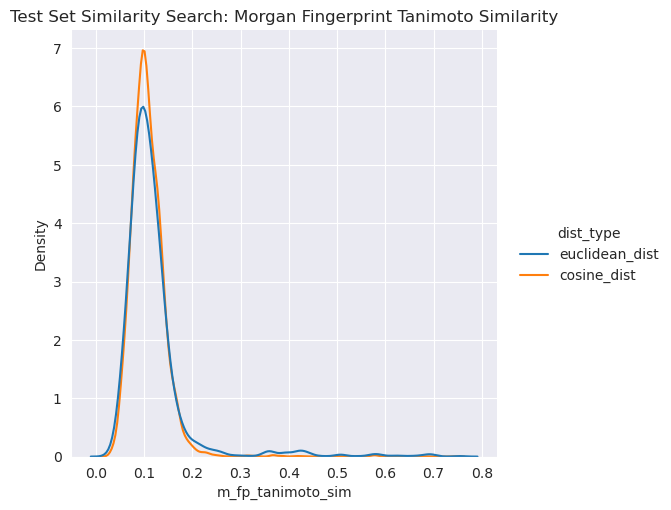

In [6]:
sns.set_style('darkgrid')
sns.displot(tmp3_df,x = 'm_fp_tanimoto_sim',  hue="dist_type", kind = 'kde')

plt.title('Test Set Similarity Search: Morgan Fingerprint Tanimoto Similarity')

In [7]:
with open("cond_generation_res/ldm_con_vae_test_set_smile_to_max_sim_generated_molecule.pkl", "rb") as f:
    ldm_vae_data = pickle.load(f)

In [8]:
ldm_vae_data

{'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_153': {'max_morgan_fp_tanimoto_sim': 0.16,
  'max_maccs_fp_tanimoto_sim': 0.6060606060606061,
  'max_fraggle_sim': 0.23624595469255663},
 'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_154': {'max_morgan_fp_tanimoto_sim': 0.1308411214953271,
  'max_maccs_fp_tanimoto_sim': 0.5084745762711864,
  'max_fraggle_sim': 0.21220159151193635},
 'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_155': {'max_morgan_fp_tanimoto_sim': 0.12,
  'max_maccs_fp_tanimoto_sim': 0.5238095238095238,
  'max_fraggle_sim': 0.21779859484777517},
 'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_156': {'max_morgan_fp_tanimoto_sim': 0.14130434782608695,
  'max_maccs_fp_tanimoto_sim': 0.5909090909090909,
  'max_fraggle_sim': 0.23411371237458195},
 'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_157': {'max_morgan_fp_tanimoto_sim': 0.1276595744680851,
  'max_maccs_fp_tanimoto_sim': 0.5797101449275363,
  'max_fraggle_sim': 0.2125},
 'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_158': {'max_morgan_fp

In [9]:
len(ldm_vae_data)

862

In [10]:
with open("cond_generation_res/ldm_con_aae_test_set_smile_to_max_sim_generated_molecule1.pkl", "rb") as f:
    ldm_aae_data = pickle.load(f)
    
with open("cond_generation_res/ldm_con_wae_test_set_smile_to_max_sim_generated_molecule.pkl", "rb") as f:
    ldm_wae_data = pickle.load(f)

In [11]:
ldm_aae_data

{'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_154': {'max_morgan_fp_tanimoto_sim': 0.14814814814814814,
  'max_maccs_fp_tanimoto_sim': 0.618421052631579,
  'max_fraggle_sim': 0.24277456647398843},
 'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_160': {'max_morgan_fp_tanimoto_sim': 0.13043478260869565,
  'max_maccs_fp_tanimoto_sim': 0.5921052631578947,
  'max_fraggle_sim': 0.24671052631578946},
 'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_162': {'max_morgan_fp_tanimoto_sim': 0.1590909090909091,
  'max_maccs_fp_tanimoto_sim': 0.6197183098591549,
  'max_fraggle_sim': 0.24675324675324675},
 'CCC(=O)NC(c1ccco1)c1cc(Br)c2cccnc2c1O_194': {'max_morgan_fp_tanimoto_sim': 0.12605042016806722,
  'max_maccs_fp_tanimoto_sim': 0.48717948717948717,
  'max_fraggle_sim': 0.3226600985221675},
 'CCC(=O)NC(c1ccco1)c1cc(Br)c2cccnc2c1O_197': {'max_morgan_fp_tanimoto_sim': 0.1301775147928994,
  'max_maccs_fp_tanimoto_sim': 0.5223880597014925,
  'max_fraggle_sim': 0.2974828375286041},
 'CCC(=O)NC(c1ccco1)c1cc(Br)c2cc

In [12]:
# ldm_vae_data = {k:ldm_vae_data[k] for k in list(ldm_vae_data)[:78]}
# ldm_wae_data = {k:ldm_wae_data[k] for k in list(ldm_wae_data)[:78]}
print(len(ldm_aae_data), len(ldm_wae_data))

912 862


In [18]:
ldm_aae_data = {k:ldm_aae_data[k] for k in list(ldm_aae_data)[:862]}
len(ldm_aae_data)

862

In [13]:
def extract_sims(data):
    max_morgan_fp_tanimoto_sim = [value['max_morgan_fp_tanimoto_sim'] for value in data.values()]
    max_maccs_fp_tanimoto_sim = [value['max_maccs_fp_tanimoto_sim'] for value in data.values()]
    max_fraggle_sim = [value['max_fraggle_sim'] for value in data.values()]
    return [max_morgan_fp_tanimoto_sim,max_maccs_fp_tanimoto_sim,max_fraggle_sim]

In [19]:
file_to_sims = {
#     "ldm_vae":extract_sims(ldm_vae_data),
#     "ldm_aae":extract_sims(ldm_aae_data),
#     "ldm_wae":extract_sims(ldm_wae_data),
    "LDM(ours)":extract_sims(ldm_aae_data)
}

for key in file_to_sims:
    file_to_sims[key].append([key for _ in range(len(file_to_sims[key][0]))])

In [20]:
file_to_sims

{'LDM(ours)': [[0.14814814814814814,
   0.13043478260869565,
   0.1590909090909091,
   0.12605042016806722,
   0.1301775147928994,
   0.1565217391304348,
   0.13194444444444445,
   0.1323529411764706,
   0.14285714285714285,
   0.15384615384615385,
   0.13286713286713286,
   0.13071895424836602,
   0.13725490196078433,
   0.14285714285714285,
   0.1511627906976744,
   0.1623931623931624,
   0.17037037037037037,
   0.17964071856287425,
   0.13855421686746988,
   0.13793103448275862,
   0.1810344827586207,
   0.1232876712328767,
   0.14788732394366197,
   0.1050228310502283,
   0.13903743315508021,
   0.11728395061728394,
   0.10152284263959391,
   0.10256410256410256,
   0.11875,
   0.12121212121212122,
   0.152,
   0.13529411764705881,
   0.14414414414414414,
   0.14193548387096774,
   0.18115942028985507,
   0.14,
   0.1487603305785124,
   0.13157894736842105,
   0.11428571428571428,
   0.11678832116788321,
   0.11214953271028037,
   0.10526315789473684,
   0.10967741935483871,
   0.1

In [16]:
tmp3_df.shape

(15350, 4)

In [21]:
# euc_df = tmp3_df.loc[tmp3_df['dist_type']=='euclidean_dist'].iloc[:78]
# cos_df = tmp3_df.loc[tmp3_df['dist_type']=='cosine_dist'].iloc[:78]

euc_df = tmp3_df.loc[tmp3_df['dist_type']=='euclidean_dist'].iloc[:862]
cos_df = tmp3_df.loc[tmp3_df['dist_type']=='cosine_dist'].iloc[:862]

In [22]:
ref_df = pd.concat([euc_df, cos_df])
ref_df

,m_fp_tanimoto_sim,maccs_fp_tanimoto_sim,fraggle_sims,dist_type
0,0.098214,0.472222,0.627219,euclidean_dist
1,0.092437,0.567568,0.494118,euclidean_dist
2,0.110092,0.460526,0.237668,euclidean_dist
3,0.180952,0.578313,0.796875,euclidean_dist
4,0.113402,0.654545,0.685484,euclidean_dist
...,...,...,...,...
8532,0.100917,0.272727,0.215743,cosine_dist
8533,0.059406,0.378788,0.494186,cosine_dist
8534,0.090909,0.632353,0.376147,cosine_dist
8535,0.157895,0.492958,0.401980,cosine_dist


In [23]:
# ref_df = tmp3_df
dfs = []
for key in file_to_sims:
    new_df = pd.DataFrame(file_to_sims[key]).T
    new_df.columns = ref_df.columns
    dfs.append(new_df)

In [24]:
tgt = pd.concat(dfs + [ref_df])
tgt

,m_fp_tanimoto_sim,maccs_fp_tanimoto_sim,fraggle_sims,dist_type
0,0.148148,0.618421,0.242775,LDM(ours)
1,0.130435,0.592105,0.246711,LDM(ours)
2,0.159091,0.619718,0.246753,LDM(ours)
3,0.12605,0.487179,0.32266,LDM(ours)
4,0.130178,0.522388,0.297483,LDM(ours)
...,...,...,...,...
8532,0.100917,0.272727,0.215743,cosine_dist
8533,0.059406,0.378788,0.494186,cosine_dist
8534,0.090909,0.632353,0.376147,cosine_dist
8535,0.157895,0.492958,0.40198,cosine_dist


In [24]:
print(sum(tgt['dist_type']=='ldm_aae'), sum(tgt['dist_type']=='ldm_vae'), sum(tgt['dist_type']=='ldm_wae'))

862 862 862


In [25]:
print(sum(tgt['dist_type']=='euclidean_dist'))
print(sum(tgt['dist_type']=='cosine_dist'))

862
862


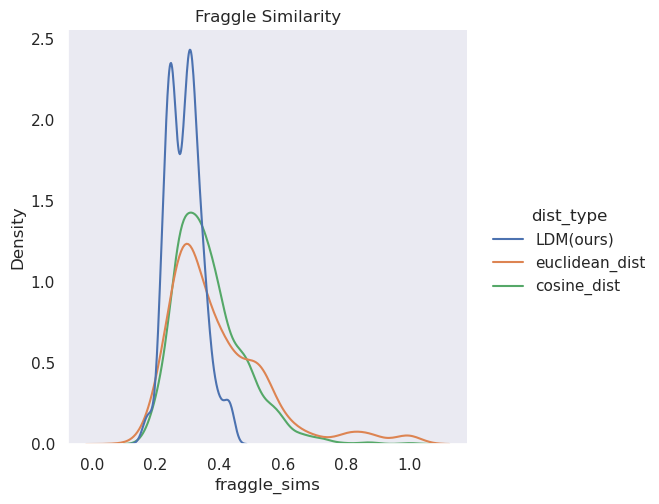

In [30]:
sns.set_theme()
sns.set_style("dark")
sns.displot(tgt,x = 'fraggle_sims',  hue="dist_type", kind = 'kde')


plt.title('Fraggle Similarity')
# plt.savefig('../test_set_similarity_search/aae_862.png', bbox_inches="tight")

Text(0.5, 1.0, 'Morgan fingerprint Tanimoto Similarity')

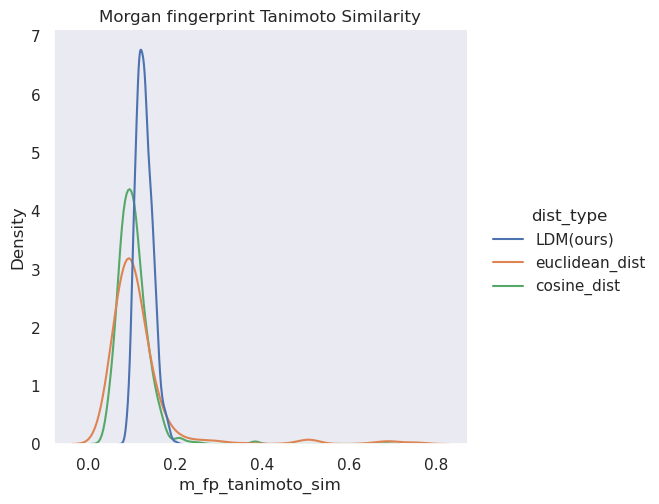

In [27]:
sns.displot(tgt,x = 'm_fp_tanimoto_sim',  hue="dist_type", kind = 'kde')
plt.title('Morgan fingerprint Tanimoto Similarity')
# plt.savefig('../plots/structural_sim_ldm/wrong_morgan_sims_1000.png', bbox_inches="tight")

Text(0.5, 1.0, 'MACCS fingerprint Tanimoto Similarity')

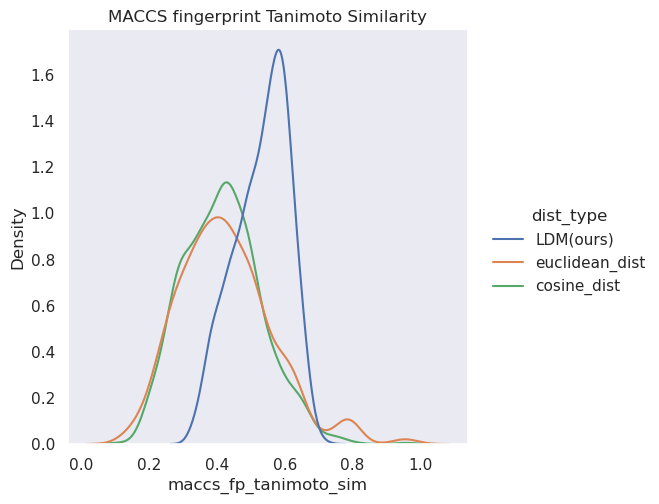

In [28]:
sns.displot(tgt,x = 'maccs_fp_tanimoto_sim',  hue="dist_type", kind = 'kde')
plt.title('MACCS fingerprint Tanimoto Similarity')
# plt.savefig('../plots/structural_sim_ldm/wrong_maccs_sims_1000.png', bbox_inches="tight")

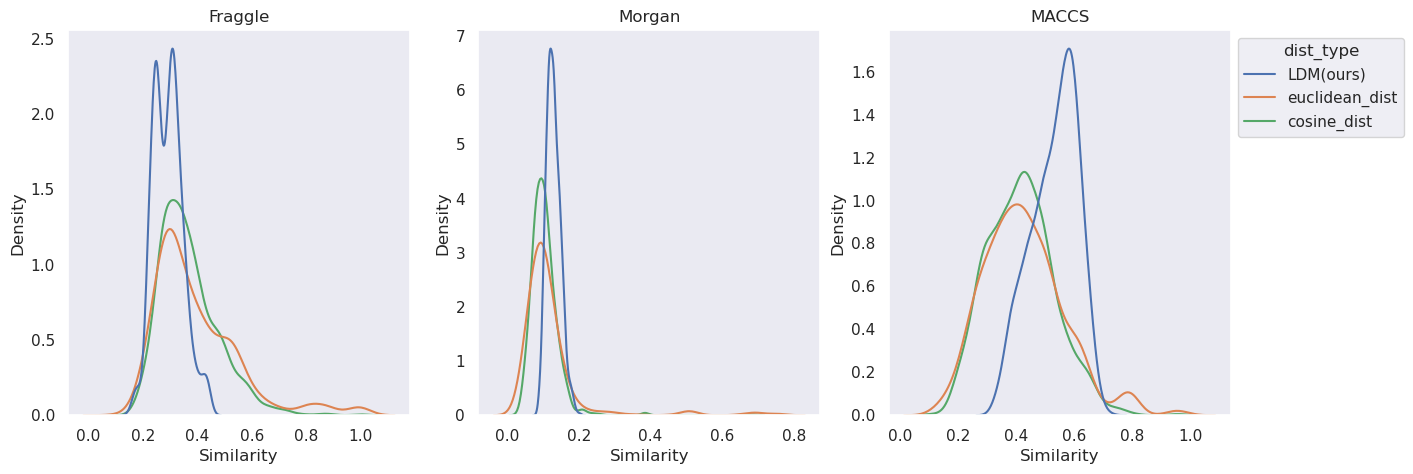

In [31]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 5))
# print(axes)
sns.kdeplot(tgt,x = 'fraggle_sims',  hue="dist_type", ax=ax1)
# axes[0].set(title='Fraggle')
ax1.get_legend().remove()
ax1.set(xlabel='Similarity', title='Fraggle')

sns.kdeplot(tgt,x = 'm_fp_tanimoto_sim',  hue="dist_type", ax=ax2)
# axes[1].set(title='Morgan fingerprint Tanimoto Similarity')
ax2.get_legend().remove()
ax2.set(xlabel='Similarity', title='Morgan')


sns.kdeplot(tgt,x = 'maccs_fp_tanimoto_sim',  hue="dist_type", ax=ax3)
# axes[2].set(title='MACCS fingerprint Tanimoto Similarity')
ax3.set(xlabel='Similarity', title='MACCS')

sns.move_legend(ax3, "upper left", bbox_to_anchor=(1, 1))
plt.show()

In [32]:
fig.savefig('../test_set_similarity_search/test_set_rediscovery_aae_862.png', bbox_inches='tight')

## Retrieve data

In [2]:
with open("cond_generation_res/ldm_con_vae_generated_molecules_and_sa_scores.pkl", "rb") as f:
    ldm_vae_mols = pickle.load(f)
    
with open("cond_generation_res/ldm_con_aae_generated_molecules_and_sa_scores1.pkl", "rb") as f:
    ldm_aae_mols = pickle.load(f)
    
with open("cond_generation_res/ldm_con_wae_generated_molecules_and_sa_scores.pkl", "rb") as f:
    ldm_wae_mols = pickle.load(f)

In [3]:
ldm_vae_mols

{'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_153': {'generated_mols': [<rdkit.Chem.rdchem.RWMol at 0x7fc81a2984a0>,
  'generated_smiles': ['CCC',
   'OCC1=CC=CN=C1',
   'N#CC1=CC=CN=C1',
   'CC(=O)NCC1=CC=CC(Cl)=C1',
   'O=C(O)NC1=CC=CC=C1Br',
   'NC(=O)CO',
   'FC1=CC=C(NCC2=NC3=CC=CC=C3S2)C=C1',
   'CN(C)S(=O)(=O)C1=CC=CC=C1',
   'CC1=CC=C(C(C)C)C=C1O',
   'CC(=O)NC1=CC=CC=C1Cl',
   'CC(N)C(Cl)C1=CC=CC=C1',
   'C=C(C)SC(=O)OCC',
   'C=CN(C)CC1=CC=CC=C1F',
   'CCCOCC1=CC=CC=C1Cl',
   'CC(C)NCC1=CC=CN=C1Cl',
   'CCN(C)CC1=CC=C(F)C=C1',
   'CCNC(=O)C1=CC=CC=C1Cl',
   'CCNCC1=CC=C(O)C(F)=C1',
   'CC(=O)NC1=CC=C(Cl)C=C1F',
   'CNCCSC1=CC=CC(F)=C1',
   'OCC(CC1=CC=CC=C1)NC1=NC2=CC=CC=C2S1',
   'CN(C)C(=S)NC1=CC=CC=C1',
   'CN(C)C(=O)CC1=NC=CS1',
   'O=C(COC1=CC=NC2=CC=CC=C21)NC1=CC=CC=C1',
   'CC(C)NC(=O)C1=CC=CC=C1F',
   'CCC(=O)NC1=CC=C(OC)C=C1',
   'CCC(C(C)=N)C1=CC=C(N(C)C)C=C1',
   'CCN(C)C(=O)C1=CC=C(F)C=C1',
   'CC=CC1=CC=C(Cl)C=C1C(=O)C(C)C',
   'COC(=O)C1=CC=C(OCC(F)(F)F)C=C1',
   

In [4]:
def smiles2mol(data):
    return [Chem.MolFromSmiles(smile) for smile in data]

In [5]:
vae_mol_sims = {}
for reference_smile_original_idx in tqdm(ldm_vae_mols):
    try:
        reference_smile = reference_smile_original_idx.rsplit("_", 1)[0]
        # print("reference smile: ", reference_smile)
        # print("relevant result:", results[reference_smile_original_idx])
        # reference_smile = reference_smile.rsplit("_", 1)[0]
        max_sim = compute_max_similarity(
            # candidate_molecules=[
            #     Chem.MolFromSmiles(smile)
            #     for smile in results[reference_smile_original_idx][
            #         "generated_smiles"
            #     ]
            # ],
            candidate_molecules=ldm_vae_mols[reference_smile_original_idx]["generated_mols"],
            reference_smile=reference_smile,
            return_max_sim_match=True
        )
        vae_mol_sims[reference_smile_original_idx] = max_sim

    except Exception as e:
        print(e)
#         pass

 65%|███████████████████████████▎              | 65/100 [03:39<01:29,  2.55s/it][01:10:46] Can't kekulize mol.  Unkekulized atoms: 12
[01:10:46] Can't kekulize mol.  Unkekulized atoms: 12
 67%|████████████████████████████▏             | 67/100 [03:39<00:46,  1.39s/it][01:10:47] Can't kekulize mol.  Unkekulized atoms: 12
[01:10:47] Can't kekulize mol.  Unkekulized atoms: 12
[01:10:47] Can't kekulize mol.  Unkekulized atoms: 12
 70%|█████████████████████████████▍            | 70/100 [03:40<00:21,  1.38it/s][01:10:47] Can't kekulize mol.  Unkekulized atoms: 12


Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[01:10:47] Can't kekulize mol.  Unkekulized atoms: 12
[01:10:47] Can't kekulize mol.  Unkekulized atoms: 12
 73%|██████████████████████████████▋           | 73/100 [03:40<00:11,  2.27it/s]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

100%|█████████████████████████████████████████| 100/100 [03:56<00:00,  2.37s/it]


In [6]:
def get_sims(data):
    sims = {}
    for reference_smile_original_idx in tqdm(data):
        try:
            reference_smile = reference_smile_original_idx.rsplit("_", 1)[0]
            # print("reference smile: ", reference_smile)
            # print("relevant result:", results[reference_smile_original_idx])
            # reference_smile = reference_smile.rsplit("_", 1)[0]
            max_sim = compute_max_similarity(
                # candidate_molecules=[
                #     Chem.MolFromSmiles(smile)
                #     for smile in results[reference_smile_original_idx][
                #         "generated_smiles"
                #     ]
                # ],
                candidate_molecules=data[reference_smile_original_idx]["generated_mols"],
                reference_smile=reference_smile,
                return_max_sim_match=True
            )
            sims[reference_smile_original_idx] = max_sim

        except Exception as e:
            print(e)
    return sims

In [7]:
ldm_aae_sims = get_sims(ldm_aae_mols)
ldm_wae_sims = get_sims(ldm_wae_mols)

  1%|▍                                          | 2/185 [00:15<23:41,  7.77s/it][01:11:19] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****



Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2022.09.1
	BOOST: 1_78



  3%|█▏                                         | 5/185 [00:31<18:11,  6.07s/it][01:11:34] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****



Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2022.09.1
	BOOST: 1_78



  5%|██                                         | 9/185 [00:54<18:48,  6.41s/it][01:11:58] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****



Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2022.09.1
	BOOST: 1_78



  6%|██▋                                       | 12/185 [01:06<14:19,  4.97s/it][01:12:10] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****



Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2022.09.1
	BOOST: 1_78



  9%|███▊                                      | 17/185 [01:20<10:06,  3.61s/it][01:12:24] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****



Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2022.09.1
	BOOST: 1_78



 12%|████▉                                     | 22/185 [01:34<08:46,  3.23s/it][01:12:38] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****

[01:12:38] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****



Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2022.09.1
	BOOST: 1_78

Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2022.09.1
	BOOST: 1_78



 15%|██████▎                                   | 28/185 [02:25<22:17,  8.52s/it][01:13:29] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****



Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2022.09.1
	BOOST: 1_78



 16%|██████▊                                   | 30/185 [02:38<19:48,  7.67s/it][01:13:42] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****



Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2022.09.1
	BOOST: 1_78



 18%|███████▋                                  | 34/185 [03:22<26:34, 10.56s/it][01:14:26] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****



Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2022.09.1
	BOOST: 1_78



 20%|████████▍                                 | 37/185 [03:56<27:58, 11.34s/it][01:15:00] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****

[01:15:00] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****

[01:15:00] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****

[01:15:00] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****



Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2022.09.1
	BOOST: 1_78

Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2022.09.1
	BOOST: 1_78

Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2022.09.1
	BOOST: 1_78

Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2022.09.1
	BOOST: 1_78



 23%|█████████▌                                | 42/185 [04:14<15:33,  6.53s/it][01:15:18] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****

[01:15:18] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****



Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2022.09.1
	BOOST: 1_78

Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2022.09.1
	BOOST: 1_78



 24%|██████████▏                               | 45/185 [04:32<14:56,  6.40s/it][01:15:36] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****



Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2022.09.1
	BOOST: 1_78



 25%|██████████▋                               | 47/185 [04:49<15:58,  6.94s/it][01:15:53] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****



Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2022.09.1
	BOOST: 1_78



 30%|████████████▋                             | 56/185 [06:54<25:25, 11.83s/it][01:17:57] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****



Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2022.09.1
	BOOST: 1_78



 32%|█████████████▌                            | 60/185 [07:19<17:54,  8.59s/it][01:18:23] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****



Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2022.09.1
	BOOST: 1_78



 35%|██████████████▌                           | 64/185 [07:46<15:24,  7.64s/it][01:18:49] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****

[01:18:50] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****

[01:18:50] Can't kekulize mol.  Unkekulized atoms: 12
 36%|███████████████▏                          | 67/185 [07:46<07:21,  3.74s/it][01:18:50] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****

[01:18:50] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpy

Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2022.09.1
	BOOST: 1_78

Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2022.09.1
	BOOST: 1_78

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Faile

[01:18:50] Can't kekulize mol.  Unkekulized atoms: 12
 38%|████████████████                          | 71/185 [07:46<03:29,  1.84s/it]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[01:18:50] Can't kekulize mol.  Unkekulized atoms: 12
 39%|████████████████▎                         | 72/185 [07:46<02:50,  1.51s/it][01:18:50] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****



Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2022.09.1
	BOOST: 1_78



 40%|████████████████▊                         | 74/185 [07:49<02:49,  1.53s/it][01:18:53] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****

[01:18:53] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****



Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2022.09.1
	BOOST: 1_78

Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2022.09.1
	BOOST: 1_78



 42%|█████████████████▋                        | 78/185 [07:56<02:53,  1.62s/it][01:18:59] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****

[01:18:59] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****

[01:18:59] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****



Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2022.09.1
	BOOST: 1_78

Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2022.09.1
	BOOST: 1_78

Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2022.09.1
	BOOST: 1_78



 45%|██████████████████▊                       | 83/185 [08:02<02:32,  1.49s/it][01:19:06] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****



Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2022.09.1
	BOOST: 1_78



 48%|████████████████████▏                     | 89/185 [08:09<02:13,  1.40s/it][01:19:13] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****

[01:19:13] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****

[01:19:13] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****



Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2022.09.1
	BOOST: 1_78

Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2022.09.1
	BOOST: 1_78

Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2022.09.1
	BOOST: 1_78



 51%|█████████████████████▎                    | 94/185 [08:12<01:22,  1.11it/s][01:19:16] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****



Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2022.09.1
	BOOST: 1_78



 52%|██████████████████████                    | 97/185 [08:15<01:25,  1.03it/s][01:19:19] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****



Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2022.09.1
	BOOST: 1_78



 55%|██████████████████████▍                  | 101/185 [08:23<02:32,  1.82s/it][01:19:27] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****

[01:19:27] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****



Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2022.09.1
	BOOST: 1_78

Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2022.09.1
	BOOST: 1_78



 56%|███████████████████████                  | 104/185 [08:26<01:55,  1.43s/it][01:19:30] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****



Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2022.09.1
	BOOST: 1_78



 57%|███████████████████████▍                 | 106/185 [08:29<01:54,  1.45s/it][01:19:33] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****



Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2022.09.1
	BOOST: 1_78



 58%|███████████████████████▉                 | 108/185 [08:32<01:53,  1.48s/it][01:19:36] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****



Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2022.09.1
	BOOST: 1_78



 60%|████████████████████████▌                | 111/185 [08:39<02:13,  1.81s/it][01:19:43] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****

[01:19:43] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****

[01:19:43] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****

[01:19:43] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****



Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2022.09.1
	BOOST: 1_78

Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2022.09.1
	BOOST: 1_78

Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2022.09.1
	BOOST: 1_78

Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2022.09.1
	BOOST: 1_78



 63%|█████████████████████████▋               | 116/185 [08:42<01:16,  1.11s/it][01:19:45] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****

[01:19:45] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****



Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2022.09.1
	BOOST: 1_78

Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2022.09.1
	BOOST: 1_78



 64%|██████████████████████████▎              | 119/185 [08:44<01:08,  1.03s/it][01:19:48] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****

[01:19:48] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****



Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2022.09.1
	BOOST: 1_78

Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2022.09.1
	BOOST: 1_78



 66%|███████████████████████████▎             | 123/185 [08:50<01:14,  1.21s/it][01:19:53] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****

[01:19:53] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****

[01:19:53] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****

[01:19:53] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****

[01:19:53] 

****
Pre-condition Violation
RingInfo not initi

Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2022.09.1
	BOOST: 1_78

Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2022.09.1
	BOOST: 1_78

Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2022.09.1
	BOOST: 1_78

Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2022.09.1
	BOOST: 1_78

Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2022.09.1
	BOOST: 1_78

Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Fai

[01:19:56] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****

 72%|█████████████████████████████▋           | 134/185 [08:52<00:29,  1.71it/s]

Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2022.09.1
	BOOST: 1_78



 74%|██████████████████████████████▏          | 136/185 [08:58<00:47,  1.03it/s][01:20:01] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****

[01:20:01] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****



Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2022.09.1
	BOOST: 1_78

Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2022.09.1
	BOOST: 1_78



 75%|██████████████████████████████▊          | 139/185 [09:00<00:43,  1.06it/s][01:20:04] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****

[01:20:04] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****



Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2022.09.1
	BOOST: 1_78

Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2022.09.1
	BOOST: 1_78



 77%|███████████████████████████████▋         | 143/185 [09:06<00:47,  1.14s/it][01:20:09] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****

[01:20:09] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****



Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2022.09.1
	BOOST: 1_78

Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2022.09.1
	BOOST: 1_78



 79%|████████████████████████████████▎        | 146/185 [09:08<00:42,  1.08s/it][01:20:12] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****



Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2022.09.1
	BOOST: 1_78



 80%|████████████████████████████████▊        | 148/185 [09:11<00:42,  1.16s/it][01:20:15] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****

[01:20:15] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****

[01:20:15] Can't kekulize mol.  Unkekulized atoms: 1
 82%|█████████████████████████████████▍       | 151/185 [09:11<00:26,  1.28it/s]

Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2022.09.1
	BOOST: 1_78

Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2022.09.1
	BOOST: 1_78

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)


[01:20:15] Can't kekulize mol.  Unkekulized atoms: 1
 83%|█████████████████████████████████▉       | 153/185 [09:12<00:19,  1.65it/s][01:20:16] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****



Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[01:20:16] Can't kekulize mol.  Unkekulized atoms: 1
 84%|██████████████████████████████████▎      | 155/185 [09:12<00:13,  2.31it/s][01:20:16] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****

[01:20:16] Can't kekulize mol.  Unkekulized atoms: 1
 85%|██████████████████████████████████▊      | 157/185 [09:12<00:09,  3.07it/s][01:20:16] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****



Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2022.09.1
	BOOST: 1_78

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int mi

[01:20:16] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15
 86%|███████████████████████████████████▍     | 160/185 [09:12<00:05,  4.32it/s]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[01:20:16] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15
 87%|███████████████████████████████████▋     | 161/185 [09:13<00:05,  4.55it/s][01:20:16] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****

[01:20:16] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****

[01:20:17] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15
 89%|████████████████████████████████████▎    | 164/185 [09:13<00:03,  6.77it/s]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2022.09.1
	BOOST: 1_78

Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2022.09.1
	BOOST: 1_78

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(

[01:20:17] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15
[01:20:17] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****

 90%|████████████████████████████████████▊    | 166/185 [09:13<00:02,  8.02it/s][01:20:17] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15
[01:20:17] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****

 91%|█████████████████████████████████████▏   | 168/185 [09:13<00:01,  8.93it/s][01:20:17] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****

[01:20:17] 

****
Pre-condition Violation
RingInfo not initialized


Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2022.09.1
	BOOST: 1_78

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int mi

[01:20:17] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15
 93%|██████████████████████████████████████   | 172/185 [09:13<00:01, 12.01it/s][01:20:17] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****

[01:20:17] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****

[01:20:17] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****

[01:20:17] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
**

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2022.09.1
	BOOST: 1_78

Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2022.09.1
	BOOST: 1_78

Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Faile

[01:20:17] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15
 96%|███████████████████████████████████████▏ | 177/185 [09:14<00:00, 15.46it/s][01:20:17] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****

[01:20:17] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****

[01:20:18] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15
 97%|███████████████████████████████████████▉ | 180/185 [09:14<00:00, 15.65it/s]

Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2022.09.1
	BOOST: 1_78

Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2022.09.1
	BOOST: 1_78

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)


[01:20:18] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15
[01:20:18] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15
 98%|████████████████████████████████████████▎| 182/185 [09:14<00:00, 11.85it/s]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[01:20:18] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15
[01:20:18] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /project/build/temp.linux-x86_64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****

100%|█████████████████████████████████████████| 185/185 [09:14<00:00,  3.00s/it]


Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2022.09.1
	BOOST: 1_78

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int mi

 65%|███████████████████████████▎              | 65/100 [06:42<02:50,  4.88s/it][01:27:01] Can't kekulize mol.  Unkekulized atoms: 12
[01:27:01] Can't kekulize mol.  Unkekulized atoms: 12
 67%|████████████████████████████▏             | 67/100 [06:42<01:27,  2.66s/it][01:27:01] Can't kekulize mol.  Unkekulized atoms: 12


Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[01:27:01] Can't kekulize mol.  Unkekulized atoms: 12
 69%|████████████████████████████▉             | 69/100 [06:42<00:50,  1.63s/it][01:27:01] Can't kekulize mol.  Unkekulized atoms: 12
[01:27:01] Can't kekulize mol.  Unkekulized atoms: 12
 71%|█████████████████████████████▊            | 71/100 [06:43<00:31,  1.07s/it]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[01:27:01] Can't kekulize mol.  Unkekulized atoms: 12
[01:27:01] Can't kekulize mol.  Unkekulized atoms: 12
 73%|██████████████████████████████▋           | 73/100 [06:43<00:19,  1.36it/s]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

100%|█████████████████████████████████████████| 100/100 [07:13<00:00,  4.34s/it]


In [8]:
print(len(ldm_aae_sims), len(ldm_wae_sims))

78 92


In [10]:
ldm_vae_sims = vae_mol_sims
ldm_vae_sims

{'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_153': {'max_morgan_fp_tanimoto_sim': (0.13333333333333333,
   'COC1=CC(C=C(C)C(=O)N2CCCCC2)=CC=C1C'),
  'max_maccs_fp_tanimoto_sim': (0.5625, 'COC1=CC=C(C2CN(C)CCC2(C)O)C=C1'),
  'max_fraggle_sim': (0.2371967654986523,
   'O=C(O)C1C(=O)NCN1C(=O)C1=CC=CC=C1')},
 'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_154': {'max_morgan_fp_tanimoto_sim': (0.1702127659574468,
   'COC1=CC=C(CNC(C)=O)C=C1C(C)O'),
  'max_maccs_fp_tanimoto_sim': (0.5846153846153846,
   'OCC(COC1=CC=C(F)C=C1)N1CCNCC1'),
  'max_fraggle_sim': (0.24555160142348753, 'CCOC(C)C(C)NC(=O)CN1CCCC1')},
 'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_155': {'max_morgan_fp_tanimoto_sim': (0.13861386138613863,
   'COC1=CC=CC=C1CN1CCNC(=O)C1'),
  'max_maccs_fp_tanimoto_sim': (0.6440677966101694,
   'COC1=CC=C(N2CCN(CCSCC=O)CC2)C=C1'),
  'max_fraggle_sim': (0.23013698630136986,
   'COCCN(CC(C)(C)NC1=CC=C(C)C=C1F)C(N)=O')},
 'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_156': {'max_morgan_fp_tanimoto_s

In [11]:
# store the sim scores
with open('cond_generation_res/ldm_vae_sim_scores.pkl', 'wb') as f:
    pickle.dump(ldm_vae_sims, f)

with open('cond_generation_res/ldm_aae_sim_scores.pkl', 'wb') as f:
    pickle.dump(ldm_aae_sims, f)
    
with open('cond_generation_res/ldm_wae_sim_scores.pkl', 'wb') as f:
    pickle.dump(ldm_wae_sims, f)

In [33]:
vae_maccs = {k:ldm_vae_sims[k]['max_maccs_fp_tanimoto_sim'][0] for k in ldm_vae_sims.keys()}
vae_maccs

{'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_153': 0.5625,
 'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_154': 0.5846153846153846,
 'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_155': 0.6440677966101694,
 'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_156': 0.5147058823529411,
 'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_157': 0.5901639344262295,
 'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_158': 0.582089552238806,
 'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_159': 0.6612903225806451,
 'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_160': 0.5846153846153846,
 'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_161': 0.5,
 'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_162': 0.5735294117647058,
 'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_163': 0.5396825396825397,
 'CCC(=O)NC(c1ccco1)c1cc(Br)c2cccnc2c1O_194': 0.453125,
 'CCC(=O)NC(c1ccco1)c1cc(Br)c2cccnc2c1O_197': 0.4426229508196721,
 'CCC(=O)NC(c1ccco1)c1cc(Br)c2cccnc2c1O_198': 0.5263157894736842,
 'CCC(=O)NC(c1ccco1)c1cc(Br)c2cccnc2c1O_199': 0.5079365079365079,
 'CC

In [34]:
max(vae_maccs.items(), key=operator.itemgetter(1))

('COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_159', 0.6612903225806451)

In [35]:
vae_max_keys = heapq.nlargest(10, vae_maccs, key=vae_maccs.get)
vae_max_keys

['COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_159',
 'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_155',
 'O=C(C1CCCCC1)N1CC(=O)N2CCc3ccccc3C2C1_2591',
 'O=C(C1CCCCC1)N1CC(=O)N2CCc3ccccc3C2C1_2584',
 'O=C(C1CCCCC1)N1CC(=O)N2CCc3ccccc3C2C1_2579',
 'O=C(C1CCCCC1)N1CC(=O)N2CCc3ccccc3C2C1_2592',
 'CC[N+](C)(CC)CCOC(=O)C(O)(c1ccccc1)C1CCCCC1_1779',
 'O=C(C1CCCCC1)N1CC(=O)N2CCc3ccccc3C2C1_2585',
 'O=C(C1CCCCC1)N1CC(=O)N2CCc3ccccc3C2C1_2588',
 'COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C)cc1OC_997']

In [36]:
vae_comp = {k:ldm_vae_sims[k]['max_maccs_fp_tanimoto_sim'][1] for k in vae_max_keys}
vae_comp

{'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_159': 'COC1=CC=C(C2COCCCN2CC(=O)O)C=C1',
 'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_155': 'COC1=CC=C(N2CCN(CCSCC=O)CC2)C=C1',
 'O=C(C1CCCCC1)N1CC(=O)N2CCc3ccccc3C2C1_2591': 'CCCC(=O)N(CC)CCN1CCOCC1',
 'O=C(C1CCCCC1)N1CC(=O)N2CCc3ccccc3C2C1_2584': 'NCCCC(=O)N1CCOCC1',
 'O=C(C1CCCCC1)N1CC(=O)N2CCc3ccccc3C2C1_2579': 'CC(=O)NCCN1CCOCC1',
 'O=C(C1CCCCC1)N1CC(=O)N2CCc3ccccc3C2C1_2592': 'C=C1CN(C(=O)C2=CC=C(F)C=C2)CCC1=O',
 'CC[N+](C)(CC)CCOC(=O)C(O)(c1ccccc1)C1CCCCC1_1779': 'CCCC(CCN(C)C)OC(C)=O',
 'O=C(C1CCCCC1)N1CC(=O)N2CCc3ccccc3C2C1_2585': 'CC=C1CCCN(CC2=CC=NC=C2)C1=O',
 'O=C(C1CCCCC1)N1CC(=O)N2CCc3ccccc3C2C1_2588': 'CC(NC1=CC=C(F)C=C1)C(=O)N1CCOCC1',
 'COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C)cc1OC_997': 'COC1=CC=CC=C1CC1CCN(C)CC1'}

In [37]:
def get_top_n_sims(sim_data, n=10):
    maccs_sim = {k:sim_data[k]['max_maccs_fp_tanimoto_sim'][0] for k in sim_data.keys()}
    top_n_keys = heapq.nlargest(n, maccs_sim, key=maccs_sim.get)
    paired_dict = {k:sim_data[k]['max_maccs_fp_tanimoto_sim'][1] for k in top_n_keys}
    return paired_dict, maccs_sim

In [38]:
vae_comp, vae_maccs = get_top_n_sims(ldm_vae_sims)
aae_comp, aae_maccs = get_top_n_sims(ldm_aae_sims)
wae_comp, wae_maccs = get_top_n_sims(ldm_wae_sims)

In [44]:
list( map(vae_maccs.get, vae_comp.keys()) )

[0.6612903225806451,
 0.6440677966101694,
 0.64,
 0.6326530612244898,
 0.6274509803921569,
 0.6274509803921569,
 0.625,
 0.6078431372549019,
 0.6,
 0.5961538461538461]

In [43]:
vae_comp

{'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_159': 'COC1=CC=C(C2COCCCN2CC(=O)O)C=C1',
 'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_155': 'COC1=CC=C(N2CCN(CCSCC=O)CC2)C=C1',
 'O=C(C1CCCCC1)N1CC(=O)N2CCc3ccccc3C2C1_2591': 'CCCC(=O)N(CC)CCN1CCOCC1',
 'O=C(C1CCCCC1)N1CC(=O)N2CCc3ccccc3C2C1_2584': 'NCCCC(=O)N1CCOCC1',
 'O=C(C1CCCCC1)N1CC(=O)N2CCc3ccccc3C2C1_2579': 'CC(=O)NCCN1CCOCC1',
 'O=C(C1CCCCC1)N1CC(=O)N2CCc3ccccc3C2C1_2592': 'C=C1CN(C(=O)C2=CC=C(F)C=C2)CCC1=O',
 'CC[N+](C)(CC)CCOC(=O)C(O)(c1ccccc1)C1CCCCC1_1779': 'CCCC(CCN(C)C)OC(C)=O',
 'O=C(C1CCCCC1)N1CC(=O)N2CCc3ccccc3C2C1_2585': 'CC=C1CCCN(CC2=CC=NC=C2)C1=O',
 'O=C(C1CCCCC1)N1CC(=O)N2CCc3ccccc3C2C1_2588': 'CC(NC1=CC=C(F)C=C1)C(=O)N1CCOCC1',
 'COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C)cc1OC_997': 'COC1=CC=CC=C1CC1CCN(C)CC1'}

In [45]:
list( map(aae_maccs.get, aae_comp.keys()) )

[0.6615384615384615,
 0.6533333333333333,
 0.6533333333333333,
 0.6521739130434783,
 0.6363636363636364,
 0.6323529411764706,
 0.6285714285714286,
 0.6235294117647059,
 0.620253164556962,
 0.620253164556962]

In [51]:
aae_comp

{'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_157': 'COC1=CC(C=CC2=CC=C(C(CCCCCCC(=O)C3CCCC3)CC(=O)C=CCC=CCCCCCCCCCCCC(=O)O)C=C2)=CC=C1N1CCC(CC2CCOCC2)CC1',
 'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_153': 'CCC=C1C2CC(C)(C3CC(CCCCCCC)C(C(COC4CCN(CC5CC(C(C6=CC=CC(OC)=C6OC)C6=CC(OC7=CC=C(OC)C(OC)=C7)=CC(OC)=C6OC)CCN5C5=CC=C(OCC)C=C5OC)CC4)OOC)C3)CC(O)C2C(CO)C1OO',
 'NS(=O)(=O)c1cc(C2(O)NC(=O)c3ccccc32)ccc1Cl_3174': 'O=S1(=O)NSC2=C3S[SH](C4=CC=C(C5=CC=CO5)C=C4)C(=C3C3=CC=C(C4=CC=C1O4)C(Cl)=C3Cl)O2',
 'NS(=O)(=O)c1cc(C2(O)NC(=O)c3ccccc32)ccc1Cl_3161': 'NC(=O)C1=CC=C(S(N)(=O)=O)C(O)=C1O',
 'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_154': 'COCCCCSC1=C(C2=C=C3C=C4C=C5OCC(OC5=C4)C(O)CC4=C(CCC4)C(CN4CCN(COC(C)=O)CC4)=CC3=C2C(C2=CC=C(CC3OC4=CC(C)=C3C=C4)C=C2)=C2CCN(C3=CC=CC=C3OC)CC2)CCC=C1',
 'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_159': 'O=C(NC1=CC=C(C2=CC=C(N3CCN(CCO)CC3)C(C3=CC=C4OCCOC4=C3)=C2)C=C1)C1=CC=C(C2=CC=C3OCCOC3=C2)C=C1',
 'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_163': 'O=C(CN1CC

In [46]:
list( map(wae_maccs.get, wae_comp.keys()) )

[0.7272727272727273,
 0.7115384615384616,
 0.6721311475409836,
 0.6716417910447762,
 0.6666666666666666,
 0.6545454545454545,
 0.6538461538461539,
 0.6507936507936508,
 0.6470588235294118,
 0.6428571428571429]

In [48]:
wae_comp

{'CC[N+](C)(CC)CCOC(=O)C(O)(c1ccccc1)C1CCCCC1_1783': 'CCCN(CCC(C1=CC=CC=C1C1=CC=CC=C1)C(C)OC(=O)C(C)(C)O)CC(C)O',
 'CC(C)(C)c1ccc(C(O)CCCN2CCC(C(O)(c3ccccc3)c3ccccc3)CC2)cc1_629': 'CC(C)C(=O)C(O)(CCCCCCCCCCN1CCN(C)CC1)C1=CC=CC=C1',
 'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_161': 'CN1CCN(CC2=CC=C(C3=CC=CC=C3C(=O)CC3C4CC5=CC=CC=C5C3CC(O)C4)C=C2)CC1',
 'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_162': 'NC(=O)CC1OC2CCCCCCCCCCC(C3=CC=CC=C3C3=CC=CC=C3)C(N3CC(O)COCC(O)C3)C1OC2',
 'CC[N+](C)(CC)CCOC(=O)C(O)(c1ccccc1)C1CCCCC1_1779': 'CCCCN(CC(O)CO)C(CC(=O)C1=CC=C(C2=CC=CC=C2)C=C1)CC(C)C',
 'CC[N+](C)(CC)CCOC(=O)C(O)(c1ccccc1)C1CCCCC1_1784': 'CCCCN(CC(C)O)C(CO)CC(=O)C1=CC=C(C2=CC=CC=C2)C=C1',
 'O=C(C1CCCCC1)N1CC(=O)N2CCc3ccccc3C2C1_2574': 'O=C(NC1=CC=C(CC(=O)N2CCC3=CC=CC=C3C2)C=C1)C1=CC=CN=C1',
 'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_154': 'OC1COCC(O)CN(C(CC2CCCCC2)C2=CC=C(F)C=C2C2=CC=CC=C2)C1',
 'CC[N+](C)(CC)CCOC(=O)C(O)(c1ccccc1)C1CCCCC1_1785': 'C1CCCCC1.CCCOC(CCC)CCCCCCCCCCCCCN(C)C(C)=O

In [49]:
wae_maccs

{'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_153': 0.640625,
 'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_154': 0.6507936507936508,
 'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_155': 0.5970149253731343,
 'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_156': 0.6056338028169014,
 'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_157': 0.5714285714285714,
 'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_158': 0.589041095890411,
 'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_159': 0.6268656716417911,
 'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_160': 0.625,
 'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_161': 0.6721311475409836,
 'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_162': 0.6716417910447762,
 'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_163': 0.6027397260273972,
 'CCC(=O)NC(c1ccco1)c1cc(Br)c2cccnc2c1O_194': 0.47540983606557374,
 'CCC(=O)NC(c1ccco1)c1cc(Br)c2cccnc2c1O_197': 0.5,
 'CCC(=O)NC(c1ccco1)c1cc(Br)c2cccnc2c1O_198': 0.5161290322580645,
 'CCC(=O)NC(c1ccco1)c1cc(Br)c2cccnc2c1O_199': 0.5081967213114754,
 'CC

In [94]:
selected_pair = [
    ['CC[N+](C)(CC)CCOC(=O)C(O)(c1ccccc1)C1CCCCC1', 'CCCN(CCC(C1=CC=CC=C1C1=CC=CC=C1)C(C)OC(=O)C(C)(C)O)CC(C)O', 0.73],
    ['CC(C)(C)c1ccc(C(O)CCCN2CCC(C(O)(c3ccccc3)c3ccccc3)CC2)cc1', 'CC(C)C(=O)C(O)(CCCCCCCCCCN1CCN(C)CC1)C1=CC=CC=C1', 0.71],
    ['COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1', 'CN1CCN(CC2=CC=C(C3=CC=CC=C3C(=O)CC3C4CC5=CC=CC=C5C3CC(O)C4)C=C2)CC1', 0.67],
#     ['COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1', 'NC(=O)CC1OC2CCCCCCCCCCC(C3=CC=CC=C3C3=CC=CC=C3)C(N3CC(O)COCC(O)C3)C1OC2'],
#     ['COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1', 'COC1=CC=C(C2COCCCN2CC(=O)O)C=C1'],
#     ['O=C(C1CCCCC1)N1CC(=O)N2CCc3ccccc3C2C1', 'CCCC(=O)N(CC)CCN1CCOCC1', 0.64],
    ['O=C(C1CCCCC1)N1CC(=O)N2CCc3ccccc3C2C1', 'O=C(NC1=CC=C(CC(=O)N2CCC3=CC=CC=C3C2)C=C1)C1=CC=CN=C1', 0.65],
#     ['NS(=O)(=O)c1cc(C2(O)NC(=O)c3ccccc32)ccc1Cl', 'O=S1(=O)NSC2=C3S[SH](C4=CC=C(C5=CC=CO5)C=C4)C(=C3C3=CC=C(C4=CC=C1O4)C(Cl)=C3Cl)O2', 0.65],
    ['NS(=O)(=O)c1cc(C2(O)NC(=O)c3ccccc32)ccc1Cl', 'NC(=O)C1=CC=C(S(N)(=O)=O)C(O)=C1O', 0.65],
    ['COc1ccc(C2CC(c3ccccc3)=NN2c2ccc(S(N)(=O)=O)cc2)cc1', 'CC1=NOC(C)=C1C1=CC=C(C2=CC(C)=C(S(N)(=O)=O)C(C)=C2C)C=C1', 0.64]
]

In [84]:
df = pd.DataFrame(selected_pair, columns=['reference_smiles', 'product_smiles', 'maccs_sim'])
df

,reference_smiles,product_smiles,maccs_sim
0,CC[N+](C)(CC)CCOC(=O)C(O)(c1ccccc1)C1CCCCC1,CCCN(CCC(C1=CC=CC=C1C1=CC=CC=C1)C(C)OC(=O)C(C)...,0.73
1,CC(C)(C)c1ccc(C(O)CCCN2CCC(C(O)(c3ccccc3)c3ccc...,CC(C)C(=O)C(O)(CCCCCCCCCCN1CCN(C)CC1)C1=CC=CC=C1,0.71
2,COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1,CN1CCN(CC2=CC=C(C3=CC=CC=C3C(=O)CC3C4CC5=CC=CC...,0.67
3,O=C(C1CCCCC1)N1CC(=O)N2CCc3ccccc3C2C1,CCCC(=O)N(CC)CCN1CCOCC1,0.64
4,NS(=O)(=O)c1cc(C2(O)NC(=O)c3ccccc32)ccc1Cl,O=S1(=O)NSC2=C3S[SH](C4=CC=C(C5=CC=CO5)C=C4)C(...,0.65
5,COc1ccc(C2CC(c3ccccc3)=NN2c2ccc(S(N)(=O)=O)cc2...,CC1=NOC(C)=C1C1=CC=C(C2=CC(C)=C(S(N)(=O)=O)C(C...,0.64


In [81]:
l1000_df.loc[l1000_df['SMILES']=='CC[N+](C)(CC)CCOC(=O)C(O)(c1ccccc1)C1CCCCC1']

,CellLine,Time,Dose,ControlIndices,TumourIndices,SMILES,DrugIndex_maccs,DrugIndex_pharmacophore2d720,DrugIndex_morgan,"DrugIndex_morgan,pharmacophore2d720",...,primary_site_large intestine,primary_site_liver,primary_site_lung,primary_site_muscle,primary_site_ovary,primary_site_prostate,primary_site_skin,primary_site_stomach,primary_site_unknown,original_idx
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
3346,A375,6.0,10.0,9050 9051 9052 9053 9054 9055 9056 9057 9058 9...,256168 256169 256170 256171,CC[N+](C)(CC)CCOC(=O)C(O)(c1ccccc1)C1CCCCC1,5240,475,8967,8968,...,0,0,0,0,0,0,1,0,0,1773
3347,A549,6.0,10.0,9252 9253 9254 9255 9256 9257 9258 9259 9260 9...,259712 259713,CC[N+](C)(CC)CCOC(=O)C(O)(c1ccccc1)C1CCCCC1,5240,475,8967,8968,...,0,0,1,0,0,0,0,0,0,1774
3348,A549,24.0,10.0,9399 9400 9401 9402 9403 9404 9405 9406 9407 9...,263144,CC[N+](C)(CC)CCOC(=O)C(O)(c1ccccc1)C1CCCCC1,5240,475,8967,8968,...,0,0,1,0,0,0,0,0,0,1775
3349,HA1E,6.0,10.0,9586 9587 9588 9589 9590 9591 9592 9593 9594 9...,269894 269895 269896,CC[N+](C)(CC)CCOC(=O)C(O)(c1ccccc1)C1CCCCC1,5240,475,8967,8968,...,0,0,0,0,0,0,0,0,0,1776
3350,HCC515,6.0,10.0,9721 9722 9723 9724 9725 9726 9727 9728 9729 9...,273246 273247 273248,CC[N+](C)(CC)CCOC(=O)C(O)(c1ccccc1)C1CCCCC1,5240,475,8967,8968,...,0,0,1,0,0,0,0,0,0,1777
3351,HEPG2,6.0,10.0,9839 9840 9841 9842 9843 9844 9845 9846 9847 9...,275341 275342 275343,CC[N+](C)(CC)CCOC(=O)C(O)(c1ccccc1)C1CCCCC1,5240,475,8967,8968,...,0,1,0,0,0,0,0,0,0,1778
3352,HT29,6.0,10.0,9919 9920 9921 9922 9923 9924 9925 9926 9927 9...,279750 279751 279752 279753 279754,CC[N+](C)(CC)CCOC(=O)C(O)(c1ccccc1)C1CCCCC1,5240,475,8967,8968,...,1,0,0,0,0,0,0,0,0,1779
3353,MCF7,6.0,10.0,10122 10123 10124 10125 10126 10127 10128 1012...,283531 283532 283533,CC[N+](C)(CC)CCOC(=O)C(O)(c1ccccc1)C1CCCCC1,5240,475,8967,8968,...,0,0,0,0,0,0,0,0,0,1780
3354,MCF7,24.0,10.0,10254 10255 10256 10257 10258 10259 10260 1026...,287007 287008 287009 287010,CC[N+](C)(CC)CCOC(=O)C(O)(c1ccccc1)C1CCCCC1,5240,475,8967,8968,...,0,0,0,0,0,0,0,0,0,1781


In [98]:
img = {}
for i, p in enumerate(tqdm(selected_pair)):
    m1 = Chem.MolFromSmiles(p[0])
    m2 = Chem.MolFromSmiles(p[1])
    sim = p[2]
    img[i] = Draw.MolsToGridImage((m1, m2), legends=('Original inhibitor', f"Similarity={sim}"), subImgSize=(250,250))
#     img[i].save('../molecule_imgs/cond_generation_100/'+i+'.png')
    png = img[i].data
    with open('../molecule_imgs/cond_generation_100/'+str(i)+'.png','wb+') as outf:
        outf.write(png)

100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 25.64it/s]


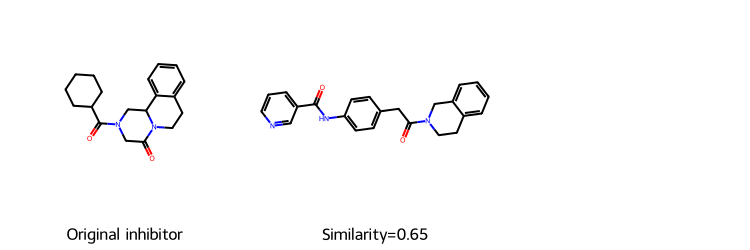

In [99]:
img[3]

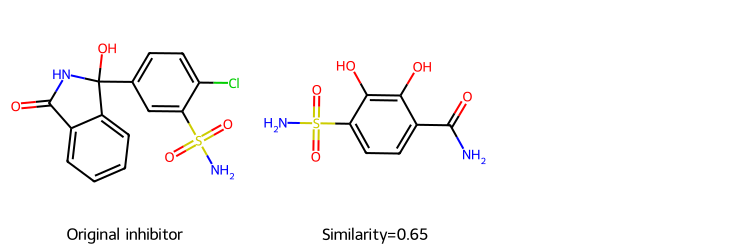

In [100]:
img[4]

# U test

In [33]:
def extract_sims_with_key(data, key):
#     max_morgan_fp_tanimoto_sim = [value['max_morgan_fp_tanimoto_sim'] for value in data.values()]
#     max_maccs_fp_tanimoto_sim = [value['max_maccs_fp_tanimoto_sim'] for value in data.values()]
#     max_fraggle_sim = [value['max_fraggle_sim'] for value in data.values()]
    max_sim = [value[key] for value in data.values()]
    return max_sim

In [34]:
maccs_sim = {
    "ldm_vae":extract_sims_with_key(ldm_vae_data, 'max_maccs_fp_tanimoto_sim'),
    "ldm_aae":extract_sims_with_key(ldm_aae_data, 'max_maccs_fp_tanimoto_sim'),
    "ldm_wae":extract_sims_with_key(ldm_wae_data, 'max_maccs_fp_tanimoto_sim'),
}
maccs_sim

{'ldm_vae': [0.6060606060606061,
  0.5084745762711864,
  0.5238095238095238,
  0.5909090909090909,
  0.5797101449275363,
  0.55,
  0.5362318840579711,
  0.5645161290322581,
  0.55,
  0.5076923076923077,
  0.6231884057971014,
  0.4603174603174603,
  0.532258064516129,
  0.453125,
  0.4444444444444444,
  0.4492753623188406,
  0.5,
  0.42028985507246375,
  0.5370370370370371,
  0.47619047619047616,
  0.4925373134328358,
  0.4307692307692308,
  0.5272727272727272,
  0.46551724137931033,
  0.5081967213114754,
  0.5192307692307693,
  0.5882352941176471,
  0.515625,
  0.5283018867924528,
  0.48148148148148145,
  0.4716981132075472,
  0.4666666666666667,
  0.54,
  0.5370370370370371,
  0.5,
  0.48484848484848486,
  0.5166666666666667,
  0.5,
  0.5471698113207547,
  0.5,
  0.46938775510204084,
  0.6041666666666666,
  0.64,
  0.5102040816326531,
  0.5925925925925926,
  0.55,
  0.5961538461538461,
  0.46153846153846156,
  0.5,
  0.5490196078431373,
  0.4897959183673469,
  0.5166666666666667,
  0.

In [35]:
tgt

,m_fp_tanimoto_sim,maccs_fp_tanimoto_sim,fraggle_sims,dist_type
0,0.148148,0.618421,0.242775,LDM(ours)
1,0.130435,0.592105,0.246711,LDM(ours)
2,0.159091,0.619718,0.246753,LDM(ours)
3,0.12605,0.487179,0.32266,LDM(ours)
4,0.130178,0.522388,0.297483,LDM(ours)
...,...,...,...,...
8532,0.100917,0.272727,0.215743,cosine_dist
8533,0.059406,0.378788,0.494186,cosine_dist
8534,0.090909,0.632353,0.376147,cosine_dist
8535,0.157895,0.492958,0.40198,cosine_dist


In [36]:
from scipy.stats import mannwhitneyu

In [31]:
vae_maccs = tgt['maccs_fp_tanimoto_sim'].loc[tgt['dist_type']=='ldm_vae'].values
vae_maccs = vae_maccs.astype('float')
vae_maccs

array([0.5625    , 0.58461538, 0.6440678 , 0.51470588, 0.59016393,
       0.58208955, 0.66129032, 0.58461538, 0.5       , 0.57352941,
       0.53968254, 0.453125  , 0.44262295, 0.52631579, 0.50793651,
       0.45901639, 0.43859649, 0.44285714, 0.47540984, 0.49152542,
       0.48387097, 0.453125  , 0.48076923, 0.51666667, 0.53703704,
       0.53846154, 0.52631579, 0.5       , 0.51923077, 0.48275862,
       0.51923077, 0.484375  , 0.49090909, 0.51851852, 0.55555556,
       0.59183673, 0.54901961, 0.57142857, 0.51851852, 0.47457627,
       0.45205479, 0.57142857, 0.5       , 0.59615385, 0.5625    ,
       0.53448276, 0.53703704, 0.54545455, 0.5625    , 0.54098361,
       0.55555556, 0.51666667, 0.5625    , 0.5625    , 0.515625  ,
       0.48      , 0.54237288, 0.52727273, 0.625     , 0.54      ,
       0.50819672, 0.54237288, 0.58      , 0.52941176, 0.57627119,
       0.59615385, 0.62745098, 0.55932203, 0.56603774, 0.63265306,
       0.60784314, 0.54545455, 0.6       , 0.64      , 0.62745

In [32]:
euc_maccs = tgt['maccs_fp_tanimoto_sim'].loc[tgt['dist_type']=='euclidean_dist'].values
euc_maccs = euc_maccs.astype('float')
euc_maccs

array([0.47222222, 0.56756757, 0.46052632, 0.57831325, 0.65454545,
       0.62686567, 0.55555556, 0.50704225, 0.54054054, 0.63013699,
       0.41666667, 0.3974359 , 0.43636364, 0.4025974 , 0.44      ,
       0.45714286, 0.36666667, 0.38235294, 0.47222222, 0.51515152,
       0.57971014, 0.36363636, 0.3974359 , 0.47457627, 0.41666667,
       0.51666667, 0.51666667, 0.51666667, 0.26388889, 0.22580645,
       0.66071429, 0.50704225, 0.66071429, 0.56363636, 0.421875  ,
       0.38235294, 0.4       , 0.44444444, 0.41176471, 0.55737705,
       0.35064935, 0.41176471, 0.51666667, 0.40983607, 0.48333333,
       0.40983607, 0.40983607, 0.25675676, 0.37209302, 0.39344262,
       0.5483871 , 0.37209302, 0.390625  , 0.47761194, 0.47297297,
       0.45205479, 0.36666667, 0.43333333, 0.40983607, 0.45205479,
       0.1884058 , 0.45205479, 0.45205479, 0.1686747 , 0.41891892,
       0.45205479, 0.18604651, 0.45205479, 0.28169014, 0.52777778,
       0.45205479, 0.21666667, 0.25925926, 0.37681159, 0.25757

In [33]:
u1, p = mannwhitneyu(vae_maccs, euc_maccs, alternative='greater')
p

2.9737992121728978e-12

In [37]:
# x_type = ['ldm_vae', 'ldm_aae', 'ldm_wae']
x_type = ['LDM(ours)']
y_type = ['euclidean_dist', 'cosine_dist']
sim_type = ['m_fp_tanimoto_sim', 'maccs_fp_tanimoto_sim', 'fraggle_sims']

In [38]:
p_dict = {}
for sim in sim_type:
    p_dict[sim] = {} 
    for x in x_type:
        for y in y_type:
           
            x_data = tgt[sim].loc[tgt['dist_type']==x].values
            x_data = x_data.astype('float')
            y_data = tgt[sim].loc[tgt['dist_type']==y].values   
            y_data = y_data.astype('float')
            
            print(x_data, y_data)
            u1, p = mannwhitneyu(x_data, y_data, alternative='greater')
            name = x+'-'+y
            p_dict[sim][name] = p

[0.14814815 0.13043478 0.15909091 0.12605042 0.13017751 0.15652174
 0.13194444 0.13235294 0.14285714 0.15384615 0.13286713 0.13071895
 0.1372549  0.14285714 0.15116279 0.16239316 0.17037037 0.17964072
 0.13855422 0.13793103 0.18103448 0.12328767 0.14788732 0.10502283
 0.13903743 0.11728395 0.10152284 0.1025641  0.11875    0.12121212
 0.152      0.13529412 0.14414414 0.14193548 0.18115942 0.14
 0.14876033 0.13157895 0.11428571 0.11678832 0.11214953 0.10526316
 0.10967742 0.11428571 0.10869565 0.14173228 0.11458333 0.11340206
 0.10280374 0.11678832 0.13380282 0.12711864 0.13157895 0.12426036
 0.12931034 0.13207547 0.15189873 0.13207547 0.12582781 0.12264151
 0.11656442 0.11038961 0.14018692 0.11235955 0.13114754 0.10416667
 0.11965812 0.10714286 0.11267606 0.13286713 0.11206897 0.12068966
 0.11805556 0.11965812 0.11627907 0.11403509 0.10606061 0.11111111
 0.13559322 0.13513514 0.10447761 0.1025641  0.12962963 0.10135135
 0.11290323 0.12264151 0.09883721 0.125      0.10869565 0.10465116
 

In [39]:
p_dict

{'m_fp_tanimoto_sim': {'LDM(ours)-euclidean_dist': 5.708495651173895e-77,
  'LDM(ours)-cosine_dist': 6.725714729106538e-95},
 'maccs_fp_tanimoto_sim': {'LDM(ours)-euclidean_dist': 7.494438029195824e-80,
  'LDM(ours)-cosine_dist': 7.824776514395961e-101},
 'fraggle_sims': {'LDM(ours)-euclidean_dist': 1.0,
  'LDM(ours)-cosine_dist': 1.0}}

In [40]:
p_df = pd.DataFrame.from_dict(p_dict)
p_df

,m_fp_tanimoto_sim,maccs_fp_tanimoto_sim,fraggle_sims
LDM(ours)-euclidean_dist,5.708496e-77,7.494438e-80,1.0
LDM(ours)-cosine_dist,6.725715e-95,7.824777e-101,1.0
